In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [2]:
home = pd.read_csv('./datasets/train.csv')

In order to make sorting / calling / organizing easier, I'm going to make all columns lowercase and remove spaces.

In [3]:
home.columns = [col.lower().replace(' ', '_') for col in home.columns]

In [4]:
home.head(1)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500


Okay, that looks good!

# Categorical Considerations
A couple categories stood out to me in particular:  

### MSZoning: Identifies the general zoning classification of the sale.

-   A Agriculture

-   C Commercial

-   FV Floating Village Residential

-   I Industrial

-   RH Residential High Density

-   RL Residential Low Density

-   RP Residential Low Density Park

-   RM Residential Medium Density

In [22]:
home['ms_zoning'].value_counts()

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

Looks like a decent distribution - I might want to combine some of the lower quantity values so I don't get caught with a meaninglessly small indicator. Worth testing.

### Neighborhood: Physical locations within Ames city limits

-   Blmngtn Bloomington Heights

-   Blueste Bluestem

-   BrDale Briardale

-   BrkSide Brookside

-   ClearCr Clear Creek

-   CollgCr College Creek

-   Crawfor Crawford

-   Edwards Edwards

-   Gilbert Gilbert

-   IDOTRR Iowa DOT and Rail Road

-   MeadowV Meadow Village

-   Mitchel Mitchell

-   Names North Ames

-   NoRidge Northridge

-   NPkVill Northpark Villa

-   NridgHt Northridge Heights

-   NWAmes Northwest Ames

-   OldTown Old Town

-   SWISU South & West of Iowa State University

-   Sawyer Sawyer

-   SawyerW Sawyer West

-   Somerst Somerset

-   StoneBr Stone Brook

-   Timber Timberland

-   Veenker Veenker

In [23]:
home['neighborhood'].value_counts()

NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64

Again, may need to combine some columns but this is a fairly good distribution and almost certainly valuable. Neighborhood reputation / brands, whether truly earned or merely imagined, have an impact on homebuyer's choices. Any neighborhood with less than 25 representatives will be combined with the next closest neighborhood.
Some obvious combo geographic based on neighborhood map (thanks Hov): https://files.slack.com/files-pri/T0351JZQ0-F01BD7FCN3Z/image.png

GrnHill + Timber  
Greens + Veenker  
Blueste + Crawfor  
NPkVill + BrDale  
Blmngtn + Gilbert  
MeadowV + Mitchell  


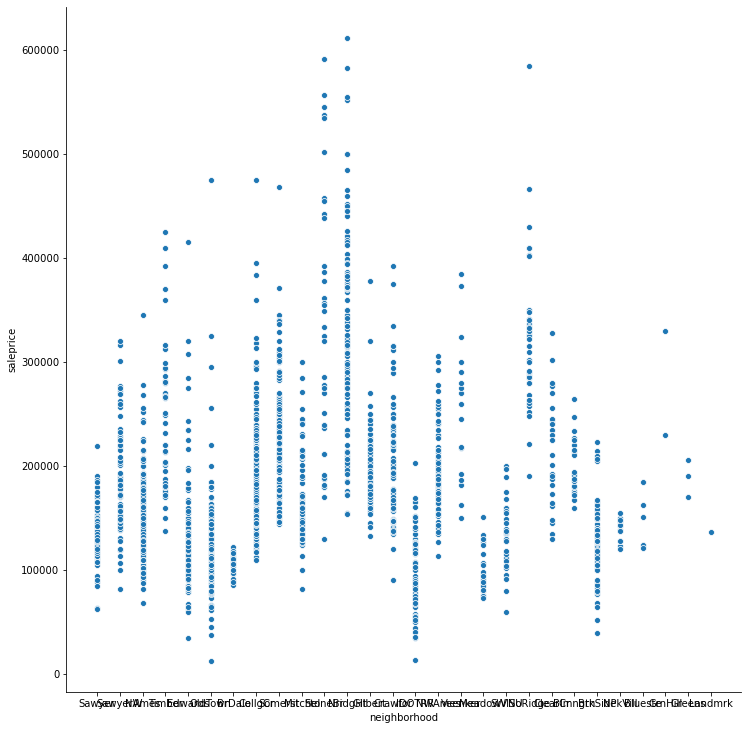

In [42]:
sns.pairplot(home, y_vars='saleprice', x_vars=['neighborhood'], height=10);

On the other hand... perhaps I could combine neighborhoods by price point rather than geography. Based on this pairplot, something to consider...

### BldgType: Type of dwelling

-   1Fam Single-family Detached

-   2FmCon Two-family Conversion; originally built as one-family dwelling

-   Duplx Duplex

-   TwnhsE Townhouse End Unit

-   TwnhsI Townhouse Inside Unit

In [25]:
home['bldg_type'].value_counts()

1Fam      1700
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: bldg_type, dtype: int64

Good distribution, definitely worth including.

### HouseStyle: Style of dwelling

-   1Story One story

-   1.5Fin One and one-half story: 2nd level finished

-   1.5Unf One and one-half story: 2nd level unfinished

-   2Story Two story

-   2.5Fin Two and one-half story: 2nd level finished

-   2.5Unf Two and one-half story: 2nd level unfinished

-   SFoyer Split Foyer

-   SLvl Split Level

In [28]:
home['house_style'].value_counts()

1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: house_style, dtype: int64

I'm going to hold back on this feature...If I do use it I will have to combine some of the smaller columns. Based on the pairplot it seems like there are values at every price point for almost every category. It does look like 1.5 unfinished and sfoyer properties tend to be lower, and 1.5fin, 2.5fin, and 2.5unfin are sort of in the same range? Not conclusive, not worth cleaning right now.

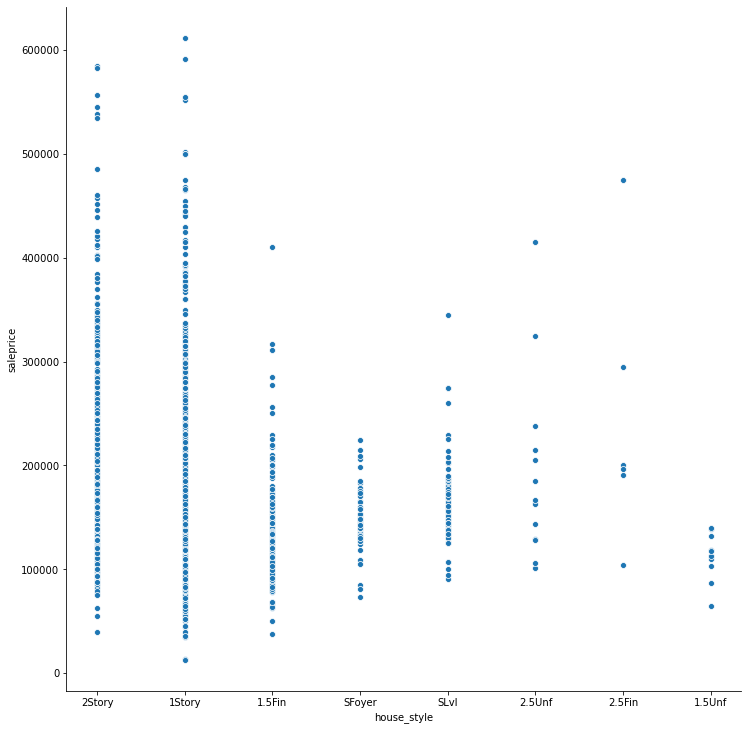

In [37]:
#plt.figure(figsize=(12,5))
sns.pairplot(home, y_vars='saleprice', x_vars=['house_style'], size=10);

### ExterCond: Present condition of the material on the exterior

-   Ex Excellent

-   Gd Good

-   TA Average/Typical

-   Fa Fair

-   Po Poor

In [38]:
home['exter_cond'].value_counts()

TA    1778
Gd     215
Fa      49
Ex       7
Po       2
Name: exter_cond, dtype: int64

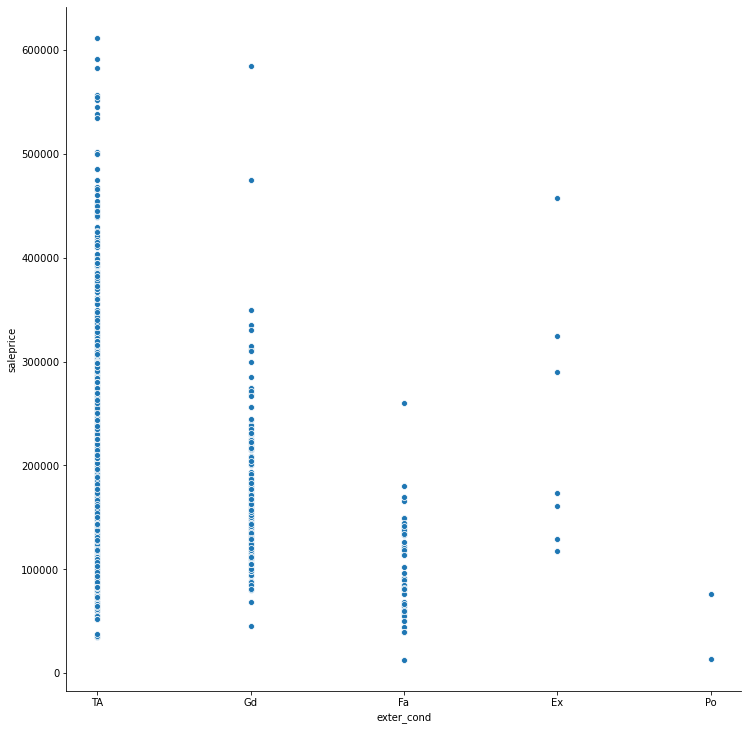

In [40]:
sns.pairplot(home, y_vars='saleprice', x_vars=['exter_cond'], height=10);

### Heating: Type of heating

-   Floor Floor Furnace

-   GasA Gas forced warm air furnace

-   GasW Gas hot water or steam heat

-   Grav Gravity furnace

-   OthW Hot water or steam heat other than gas

-   Wall Wall furnace

In [11]:
#notes

## CentralAir: Central air conditioning

-   N No

-   Y Yes

In [12]:
#notes

## KitchenQual: Kitchen quality

-   Ex Excellent

-   Gd Good

-   TA Typical/Average

-   Fa Fair

-   Po Poor

In [13]:
#notes

## MoSold: Month Sold

In [17]:
#notes

## Fence: Fence quality

-   GdPrv Good Privacy

-   MnPrv Minimum Privacy

-   GdWo Good Wood

-   MnWw Minimum Wood/Wire

-   NA No Fence

In [14]:
#notes

YrSold: Year Sold

In [15]:
#note

## SaleType: Type of sale

-   WD Warranty Deed - Conventional

-   CWD Warranty Deed - Cash

-   VWD Warranty Deed - VA Loan

-   New Home just constructed and sold

-   COD Court Officer Deed/Estate

-   Con Contract 15% Down payment regular terms

-   ConLw Contract Low Down payment and low interest

-   ConLI Contract Low Interest

-   ConLD Contract Low Down

-   Oth Other

In [16]:
#notes